In [1]:
%%capture
import sys
!pip install tensorflow-addons
!pip install tslearn
!git clone https://github.com/ICascha/QuantGANs-replication.git
!unzip QuantGANs-replication/trained_models/trained_generator_SP500 -d QuantGANs-replication/trained_models
sys.path.append('/content/QuantGANs-replication/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from backend.tcn import *

from tslearn import datasets
from tensorflow import one_hot
from google.colab import files

In [3]:
d = datasets.UCR_UEA_datasets(use_cache=False)
X_train, y_train, X_test, y_test = \
    d.load_dataset('UWaveGestureLibrary')

n_catagories = 8

X_train = np.expand_dims(np.moveaxis(X_train, 1, -1), -1)
X_test = np.expand_dims(np.moveaxis(X_test, 1, -1), -1)
y_train = one_hot(y_train.astype('float')-1, n_catagories)
y_test = one_hot(y_test.astype('float')-1, n_catagories)

In [4]:
from tensorflow.keras.layers import PReLU, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow_addons.layers import SpectralNormalization

def make_TCN_classifier(dilations, fixed_filters, moving_filters, use_batchNorm, one_series_output, sigmoid, input_dim, block_size=2):

    rfs = receptive_field_size(dilations, block_size)
    n_series = input_dim[0]

    input_layer = Input(shape=input_dim)
    cropping = 0
    prev_layer, skip_layer, _ = add_temporal_block(input_layer, None, 1, 1, fixed_filters, moving_filters, n_series, rfs, block_size, use_batchNorm, cropping)
                
    for dilation in dilations:
        prev_layer, skip_layer, cropping = add_temporal_block(prev_layer, skip_layer, 2, dilation, fixed_filters, moving_filters, n_series, rfs, block_size, use_batchNorm, cropping)

    # dense output, dont copress filters before flattening
    output_layer = PReLU(shared_axes=[2, 3])(skip_layer)
    output_layer = Flatten()(output_layer)
    output_layer = Dense(n_catagories)(output_layer)
    output_layer = PReLU()(output_layer)
    output_layer = Dense(n_catagories, activation='softmax')(output_layer)
    

    return Model(input_layer, output_layer)

In [5]:
filters = [(20, 0), (15, 5), (15, 0), (10, 10)]
results = []
N = 10

input_dim = [3, 315, 1]

for filter in filters:
    combined_result = []

    for j in range(N):
        model = make_TCN_classifier(2**np.arange(7), filter[0], filter[0], False, False, False, input_dim)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

        history = model.fit(X_train, y_train, 
                                validation_data=(X_test, y_test), epochs=100, verbose=False)
        
        combined_result.append(history.history['val_accuracy'])
    results.append(np.array(combined_result))

0
0
0
0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

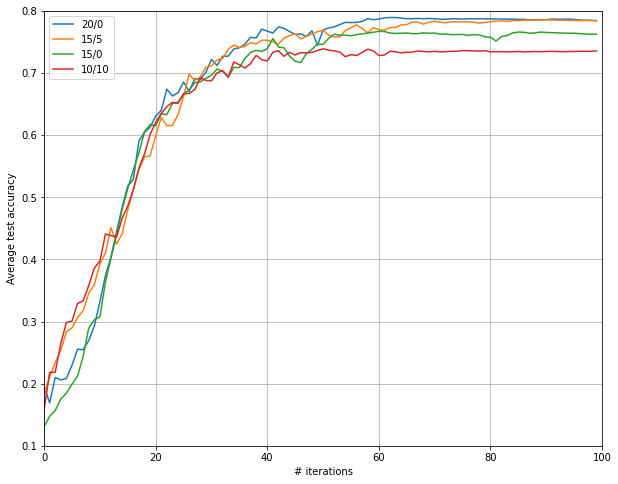

In [6]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.array(results)[:, :, :].mean(axis=1).T)
ax.legend(['20/0', '15/5', '15/0', '10/10'])
ax.set_xlabel('# iterations')
ax.set_ylabel('Average test accuracy')
ax.grid()
ax.set_xlim(0, 100)
ax.set_ylim(0.1, 0.8)

plt.savefig('acc_different_filters.png', dpi=300)
files.download("acc_different_filters.png");

In [7]:
filters = [(20, 0), (15, 5)]
results = []
N = 10

input_dim = [3, 315, 1]

for filter in filters:
    combined_result = []

    for j in range(N):
        model = make_TCN_classifier(2**np.arange(7), filter[0], filter[0], False, False, False, input_dim)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
        # drop out data from a single coordinate randomly every validation run
        history = model.fit(X_train, y_train, 
                                # not the most efficient way to do it perhaps (or most legible), we swap the series and the axis and then multiply with a mask like [1,1,0], then reswap axis
                                validation_data=(np.moveaxis(np.moveaxis(np.moveaxis(X_test, 1, -1) * np.random.choice([1,1,0], size=3, replace=False), 1, -1), 1, -1) , y_test), epochs=100, verbose=False)
        
        combined_result.append(history.history['val_accuracy'])
    results.append(np.array(combined_result))

0
0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

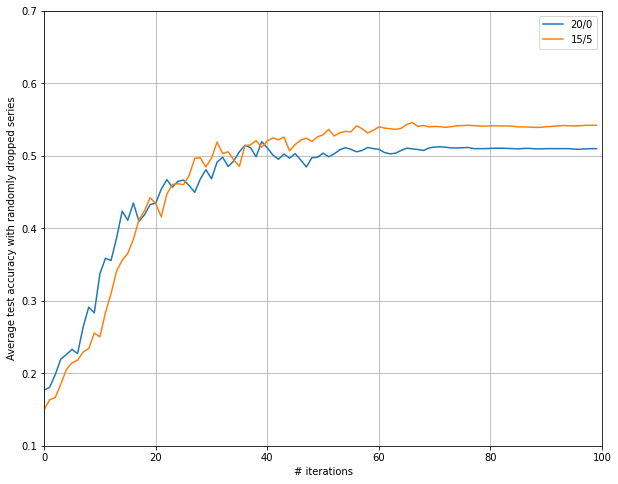

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.array(results).mean(axis=1).T)
ax.legend(['20/0', '15/5', '15/0', '10/10'])
ax.set_xlabel('# iterations')
ax.set_ylabel('Average test accuracy with randomly dropped series')
ax.grid()
ax.set_xlim(0, 100)
ax.set_ylim(0.1, 0.7)

plt.savefig('acc_dropped_axis_filters.png', dpi=300)
files.download("acc_dropped_axis_filters.png");

In [9]:
make_TCN_classifier(2**np.arange(7), 20, 0, False, False, False, input_dim).count_params()/make_TCN_classifier(2**np.arange(7), 15, 0, False, False, False, input_dim).count_params()

1.651082968398627

In [10]:
make_TCN_classifier(2**np.arange(7), 15, 5, False, False, False, input_dim).count_params()/make_TCN_classifier(2**np.arange(7), 15, 0, False, False, False, input_dim).count_params()

1.3712865427861285